# Exploratory and Descriptive Analysis (EDA) Parte II 

In [119]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import xgboost as xgb

from matplotlib import gridspec 
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RANSACRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor


# Funciones auxiliares

In [44]:
def metricas_validacion_cruzada(modelo, modelo_nombre,k, X, y ):
    MAE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_mean_absolute_error')
    r2 = cross_val_score(modelo, X, y, cv=k, scoring = 'r2')
    MSE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_mean_squared_error')
    RMSE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_root_mean_squared_error')


    return pd.DataFrame({'Modelo': modelo_nombre,
                    'MAE' : str(round(np.mean(-MAE),5))+'+/-'+str(round(np.std(-MAE),2)),
                  'MSE' : str(round(np.mean(-MSE),5))+'+/-'+str(round(np.std(-MSE),2)),
                  'RMSE' : str(round(np.mean(-RMSE),5))+'+/-'+str(round(np.std(-RMSE),2)),
                'R2' : str(round(np.mean(r2),5))+'+/-'+str(round(np.std(-r2),2))
    }, index = [0])

In [45]:
def metricas(modelo, yobs, yhat):
    # MAE 
    MAE = np.mean(np.abs(yobs-yhat))
    # MAPE
    MAPE = 100*np.mean(np.abs((yobs-yhat)/yobs))
    # RMSE
    RMSE = np.sqrt(np.mean((yobs-yhat)**2))
    # MSE
    MSE = np.mean((yobs-yhat)**2)
    # R2
    R2 = r2_score(yobs, yhat) 
    
    return pd.DataFrame({'Modelo' : modelo,
                         'MAE' : MAE,
                         'MAPE' : MAPE, 
                         'RMSE' : RMSE,
                         'MSE' : MSE, 
                         'R2': R2
    }, index =[0])

## Ejemplo

In [4]:
def validacion_cruzada(modelo,X,y, k_folds):
    metrica = pd.DataFrame()
    for i in range(k_folds):
        X_train_vc = X.drop(X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds)].index)
        y_train_vs = y.drop(y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)].index)
        X_test_vc = X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds)]
        y_test_vs = y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)]
        ajuste = LinearRegression().fit(X_train_vc,y_train_vs)
        y_ajustados = ajuste.predict(X_test_vc)
        metrica = metrica.append(metricas('Doblez '+ str(i), y_test_vs ,y_ajustados))
        
        salida = pd.DataFrame({'MAE': str(round(metrica['MAE'].mean(),2))+'+/-'+str(round(np.std(metrica['MAE']),2)),
                               'MAPE': str(round(metrica['MAPE'].mean(),2))+'+/-'+str(round(np.std(metrica['MAPE']),2)),
                               'RMSE': str(round(metrica['RMSE'].mean(),2))+'+/-'+str(round(np.std(metrica['RMSE']),2)),
                               'MSE':   str(round(metrica['MSE'].mean(),2))+'+/-'+str(round(np.std(metrica['MSE']),2)),
                               'R2':    str(round(metrica['R2'].mean(),2))+'+/-'+str(round(np.std(metrica['R2']),2))
                              }, index = [0])
    return salida

# Procesamiento de Datos

In [46]:
data = pd.read_csv('../data/kc_house_data.csv')

In [47]:
data['date'] = pd.to_datetime(data['date'], format ='%Y-%m-%d')
data['yr_built'] = pd.to_datetime(data['yr_built'], format = '%Y').dt.year
data.loc[data['yr_renovated']!= 0, 'yr_renovated' ] = pd.to_datetime(data.loc[data['yr_renovated']!= 0, 'yr_renovated' ], format = '%Y').dt.year

In [48]:
data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

Limitemos nuestro análisis a propiedades de menos de un millón de dólares

In [49]:
data = data[data['price']<2000000]

data = data[(data['bedrooms']<6)&
     (data['sqft_living']<7000)&
     (data['sqft_above']<5000)&
     (data['sqft_basement']<3000)&
     (data['sqft_lot15']<20000)]

## Hay relación entre el precio y la fecha de la venta? 

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [10]:
data['month'] = data['date'].dt.month
data['week_of_year'] = data['date'].dt.weekofyear
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek


C:\Users\Windows\AppData\Local\Temp/ipykernel_16408/3071502936.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week_of_year'] = data['date'].dt.weekofyear


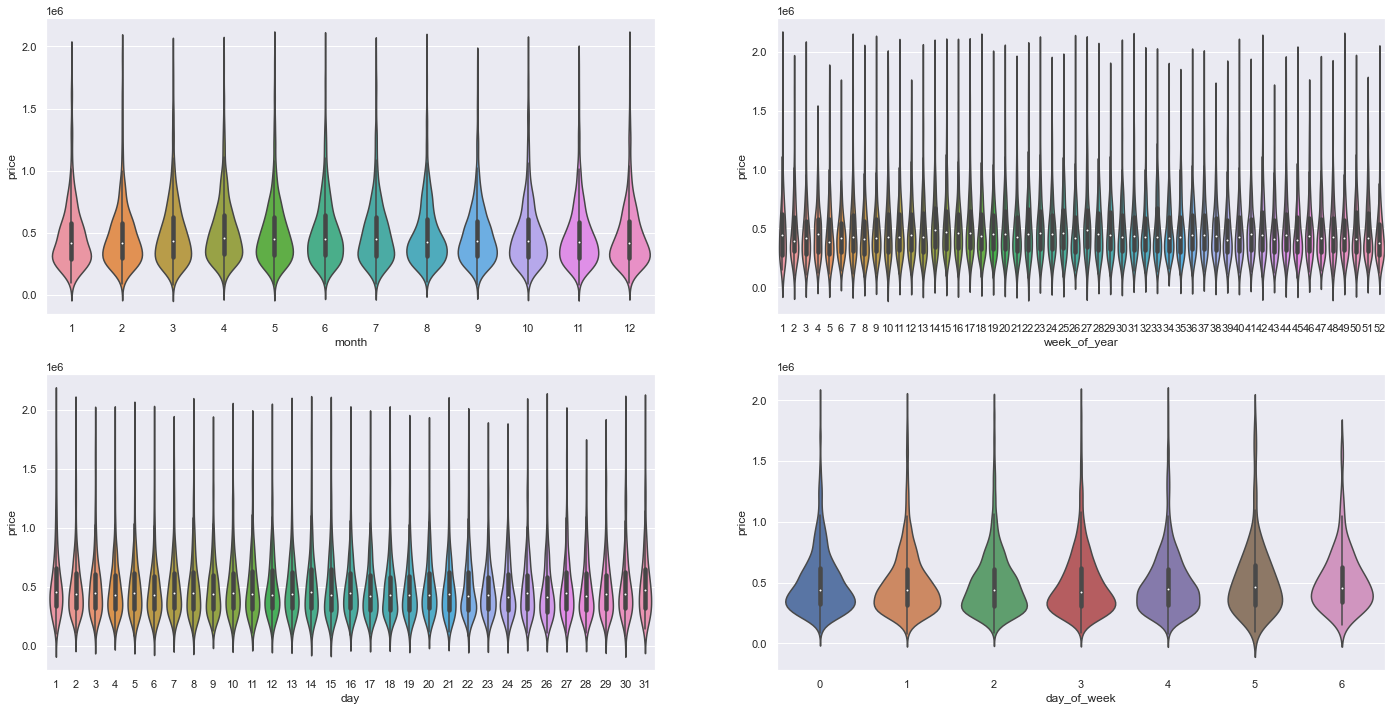

In [11]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(2, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.violinplot(x = 'month', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.violinplot(x = 'week_of_year', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.violinplot(x = 'day', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.violinplot(x = 'day_of_week', y='price', data = data)

## Relación del precio con Habitaciones y baños?

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

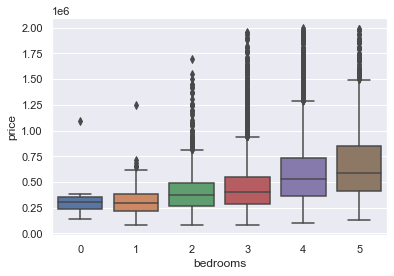

In [12]:
sns.boxplot(x='bedrooms', y='price', data = data)

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

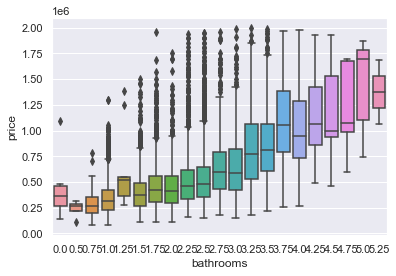

In [13]:
sns.boxplot(x='bathrooms', y='price', data = data)

## Relación entre diferentes categorías de área y precio

In [14]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'week_of_year',
       'day', 'day_of_week'],
      dtype='object')

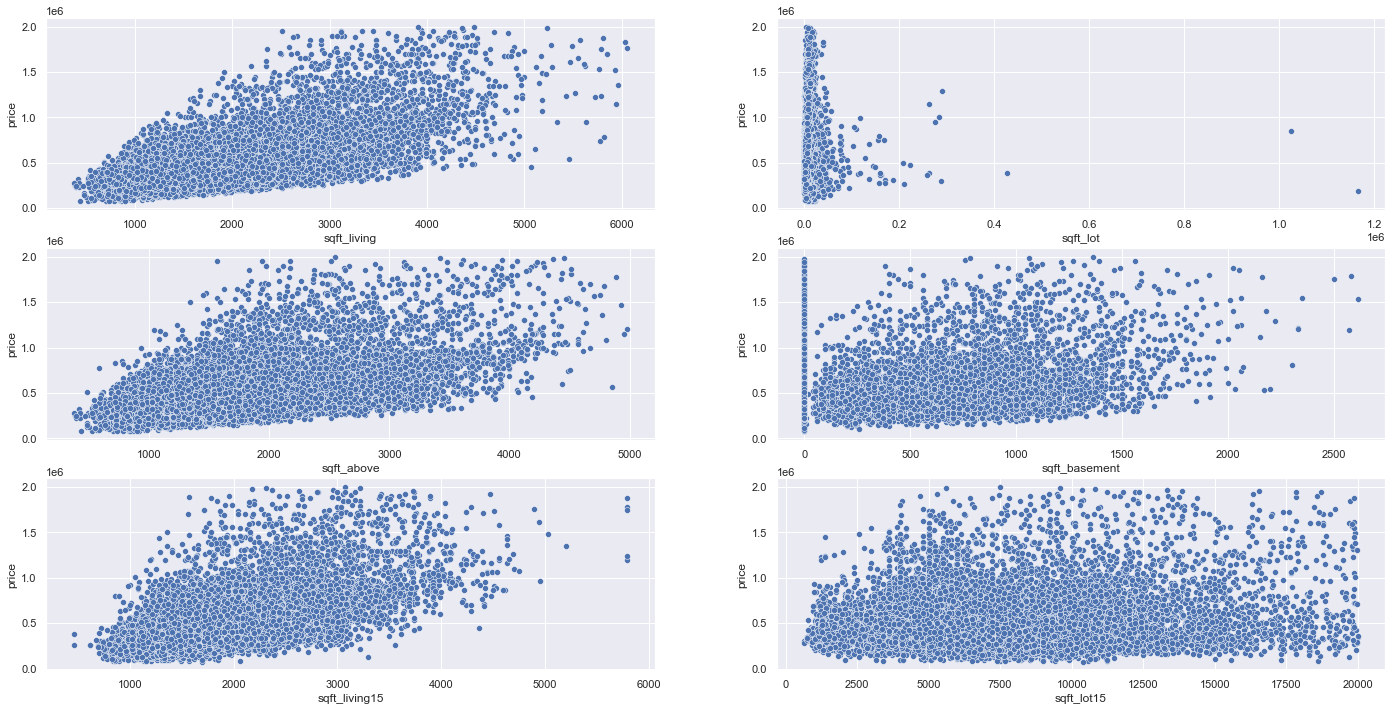

In [15]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(3, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.scatterplot(x = 'sqft_living', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.scatterplot(x = 'sqft_lot', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.scatterplot(x = 'sqft_above', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.scatterplot(x = 'sqft_basement', y='price', data = data)
ax5 = fig.add_subplot(gs[2,0])
ax5 = sns.scatterplot(x = 'sqft_living15', y='price', data = data)
ax6 = fig.add_subplot(gs[2,1])
ax6 = sns.scatterplot(x = 'sqft_lot15', y='price', data = data)

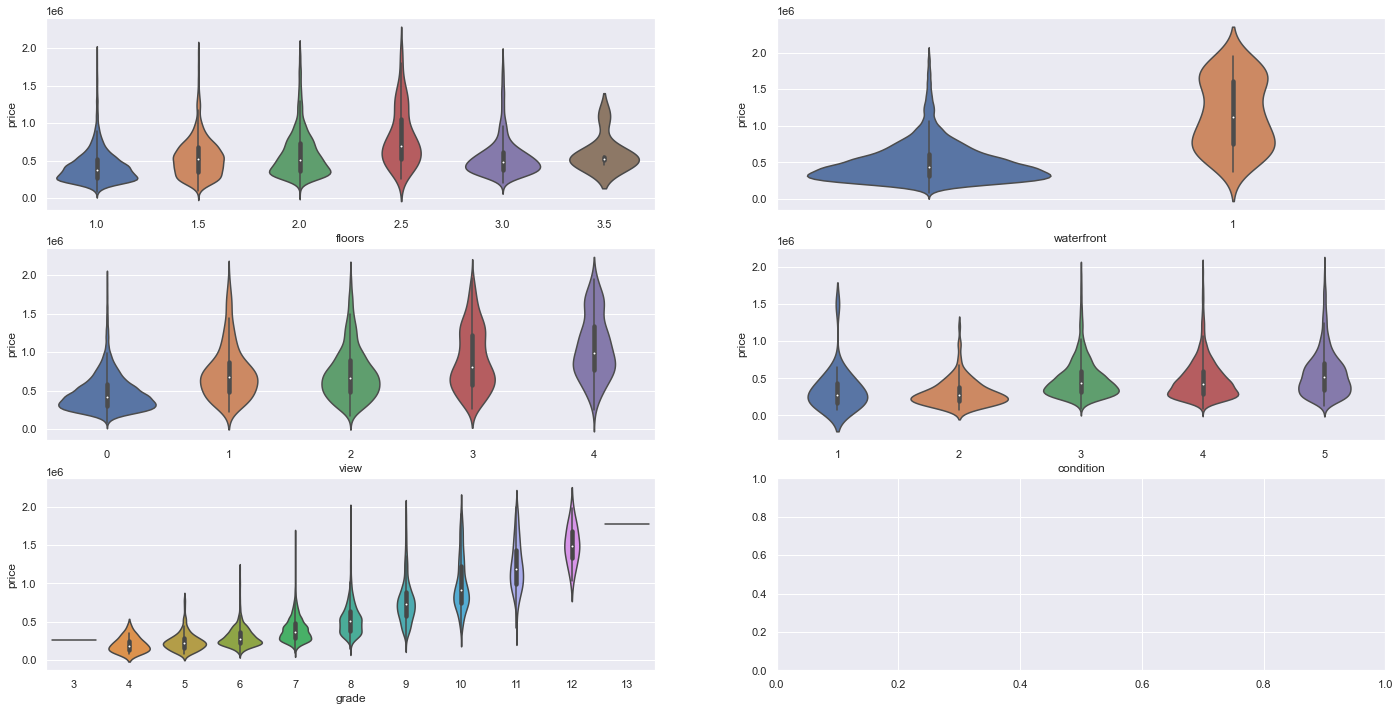

In [16]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(3, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.violinplot(x = 'floors', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.violinplot(x = 'waterfront', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.violinplot(x = 'view', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.violinplot(x = 'condition', y='price', data = data)
ax5 = fig.add_subplot(gs[2,0])
ax5 = sns.violinplot(x = 'grade', y='price', data = data)
ax6 = fig.add_subplot(gs[2,1])
# ax6 = sns.scatterplot(x = 'sqft_lot15', y='price', data = data)

# Preparación de la variables

In [50]:
data['yr_renovated_dummy'] = data['yr_renovated'].apply(lambda x: 1 if x!=0 else 0)

In [51]:
columns = ['price','bedrooms', 'bathrooms', 'sqft_living', 'floors','waterfront', 'view', 'condition', 'grade',
          'yr_built', 'yr_renovated_dummy']
data_aux = data[columns]

In [52]:
data_aux['property_age'] = 2015-data_aux['yr_built']

C:\Users\Windows\AppData\Local\Temp/ipykernel_16408/2804049904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aux['property_age'] = 2015-data_aux['yr_built']


In [53]:
data_aux.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated_dummy,property_age
0,221900.0,3,1.00,1180,1.0,0,0,3,7,1955,0,60
1,538000.0,3,2.25,2570,2.0,0,0,3,7,1951,1,64
2,180000.0,2,1.00,770,1.0,0,0,3,6,1933,0,82
3,604000.0,4,3.00,1960,1.0,0,0,5,7,1965,0,50
4,510000.0,3,2.00,1680,1.0,0,0,3,8,1987,0,28


La existencia de la variable $y$ es lo que permite que nos refiramos a este tipo de problemas como **Aprendizaje Supervisado**

In [54]:
# Matriz de información
X = data_aux.drop(columns = ['price'])
# Variable respuesta
y = data_aux['price']

## Validación de modelo (Train vs Test)

[Documentación Oficial de Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

Se genera la partición en conjunto de entrenamiento (80%) y conjunto de test (20%)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
X_train.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated_dummy,property_age
17118,4,3.50,3920,2.0,0,0,3,9,2004,0,11
15044,2,1.75,1660,1.0,0,0,3,7,1942,0,73
11264,3,1.75,2060,1.0,0,0,5,7,1951,0,64
15673,3,1.50,1180,1.0,0,0,4,7,1959,0,56
13362,3,2.50,2770,2.0,0,2,3,9,1992,0,23


### Transformando X_train

In [57]:
for item in X_train.columns.to_list():
    if item != 'sqft_living':
        scaler = MinMaxScaler()
    if item == 'sqft_living':
        scaler = RobustScaler()
    X_train[[item]] = scaler.fit_transform(X_train[[item]])
    joblib.dump(scaler, '../parameters/'+item+'.sav')

In [59]:
X_train.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated_dummy,property_age
17118,0.8,0.666667,2.019417,0.4,0.0,0.0,0.50,0.6,0.904348,0.0,0.095652
15044,0.4,0.333333,-0.174757,0.0,0.0,0.0,0.50,0.4,0.365217,0.0,0.634783
11264,0.6,0.333333,0.213592,0.0,0.0,0.0,1.00,0.4,0.443478,0.0,0.556522
15673,0.6,0.285714,-0.640777,0.0,0.0,0.0,0.75,0.4,0.513043,0.0,0.486957
13362,0.6,0.476190,0.902913,0.4,0.0,0.5,0.50,0.6,0.800000,0.0,0.200000


In [60]:
X_train = X_train.drop(columns = ['yr_built'])

In [61]:
X_train.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_renovated_dummy,property_age
17118,0.8,0.666667,2.019417,0.4,0.0,0.0,0.50,0.6,0.0,0.095652
15044,0.4,0.333333,-0.174757,0.0,0.0,0.0,0.50,0.4,0.0,0.634783
11264,0.6,0.333333,0.213592,0.0,0.0,0.0,1.00,0.4,0.0,0.556522
15673,0.6,0.285714,-0.640777,0.0,0.0,0.0,0.75,0.4,0.0,0.486957
13362,0.6,0.476190,0.902913,0.4,0.0,0.5,0.50,0.6,0.0,0.200000


In [62]:
y_train = np.log1p( y_train )

In [63]:
y_train.head()

17118    13.697854
15044    13.089842
11264    13.122265
15673    12.873905
13362    13.527763
Name: price, dtype: float64

### Transformando X_test

In [64]:
X_test.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated_dummy,property_age
4886,4,2.5,2800,2.0,0,0,3,8,1993,0,22
7089,3,1.0,1270,1.0,0,0,3,7,1953,0,62
11444,5,1.0,1120,1.5,0,0,4,7,1962,0,53
8364,3,1.0,1050,1.0,0,0,3,7,1941,0,74
3614,4,2.5,3140,2.0,0,0,3,9,1993,0,22


In [65]:
for item in X_test.columns.to_list(): 
    scaler = joblib.load('../parameters/'+item+'.sav')
    X_test[[item]] = scaler.transform(X_test[[item]])

In [66]:
X_test.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated_dummy,property_age
4886,0.8,0.476190,0.932039,0.4,0.0,0.0,0.50,0.5,0.808696,0.0,0.191304
7089,0.6,0.190476,-0.553398,0.0,0.0,0.0,0.50,0.4,0.460870,0.0,0.539130
11444,1.0,0.190476,-0.699029,0.2,0.0,0.0,0.75,0.4,0.539130,0.0,0.460870
8364,0.6,0.190476,-0.766990,0.0,0.0,0.0,0.50,0.4,0.356522,0.0,0.643478
3614,0.8,0.476190,1.262136,0.4,0.0,0.0,0.50,0.6,0.808696,0.0,0.191304


In [67]:
X_test = X_test.drop(columns= ['yr_built'])

In [68]:
X_test.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_renovated_dummy,property_age
4886,0.8,0.476190,0.932039,0.4,0.0,0.0,0.50,0.5,0.0,0.191304
7089,0.6,0.190476,-0.553398,0.0,0.0,0.0,0.50,0.4,0.0,0.539130
11444,1.0,0.190476,-0.699029,0.2,0.0,0.0,0.75,0.4,0.0,0.460870
8364,0.6,0.190476,-0.766990,0.0,0.0,0.0,0.50,0.4,0.0,0.643478
3614,0.8,0.476190,1.262136,0.4,0.0,0.0,0.50,0.6,0.0,0.191304


# Machine Learning

Métricas usuales para evaluar modelos de Machine learning disponibles [aquí](https://scikit-learn.org/stable/modules/model_evaluation.html)

## Regresión Lineal

In [69]:
ajuste = LinearRegression().fit(X_train,y_train)

In [70]:
X_test.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_renovated_dummy,property_age
4886,0.8,0.476190,0.932039,0.4,0.0,0.0,0.50,0.5,0.0,0.191304
7089,0.6,0.190476,-0.553398,0.0,0.0,0.0,0.50,0.4,0.0,0.539130
11444,1.0,0.190476,-0.699029,0.2,0.0,0.0,0.75,0.4,0.0,0.460870
8364,0.6,0.190476,-0.766990,0.0,0.0,0.0,0.50,0.4,0.0,0.643478
3614,0.8,0.476190,1.262136,0.4,0.0,0.0,0.50,0.6,0.0,0.191304


In [71]:
y_ajustado = ajuste.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

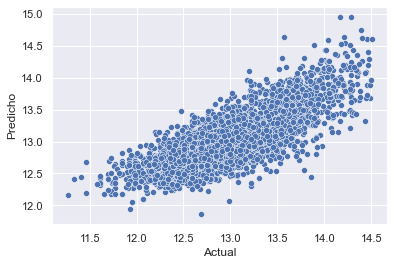

In [72]:
df = pd.DataFrame({'Actual': np.log1p( y_test ), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

### Validación test-train

In [73]:
metricas('regresión', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,regresión,0.250951,1.938193,0.314264,0.098762,0.593824


In [74]:
metricas('regresión',y_test,np.expm1(y_ajustado))

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,regresión,122494.01828,26.241176,177158.925534,3.138528e+10,0.586972


### Validación cruzada

In [75]:
validacion_cruzada('Regresión', X,y, 10)

,MAE,MAPE,RMSE,MSE,R2
0,121199.36+/-2381.99,27.68+/-1.93,167917.47+/-5986.09,28232109291.42+/-2015356410.57,0.62+/-0.01


In [76]:
for item in X.columns.to_list():
    if item != 'sqft_living':
        scaler = MinMaxScaler()
    if item == 'sqft_living':
        scaler = RobustScaler()
    X[[item]] = scaler.fit_transform(X[[item]])

In [77]:
y = np.log1p(y)

In [78]:
metricas_validacion_cruzada(LinearRegression(), 'Regresión Lineal', 10, X,y)

,Modelo,MAE,MSE,RMSE,R2
0,Regresión Lineal,0.25016+/-0.01,0.09774+/-0.01,0.31239+/-0.01,0.59502+/-0.01


In [79]:
metricas_validacion_cruzada(LinearRegression(), 'Regresión Lineal', 10, X,y)

,Modelo,MAE,MSE,RMSE,R2
0,Regresión Lineal,0.25016+/-0.01,0.09774+/-0.01,0.31239+/-0.01,0.59502+/-0.01


## Regresión Ridge

Para leer más acerca de la regresión [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) y acerca de Parameter Fine Tuning, vea [acá](https://medium.com/fintechexplained/how-to-fine-tune-your-machine-learning-models-to-improve-forecasting-accuracy-e18e67e58898) o [acá](https://machinelearningmastery.com/what-is-bayesian-optimization/)

In [80]:
params = {'alpha' : [1e-15,1e-10,1e-5,1e-3,0.1, 0.3, 0.5, 0.8,1,5,10,20,30]}
ridge = Ridge()
ridge_regression = GridSearchCV(ridge, params,scoring ='neg_mean_squared_error' , cv = 5)
ridge_regression.fit(X,y)

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.38974e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.1104e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.08943e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 0.3, 0.5,
                                   0.8, 1, 5, 10, 20, 30]},
             scoring='neg_mean_squared_error')

In [81]:
print(ridge_regression.best_params_)
print(ridge_regression.best_score_)

{'alpha': 0.1}
-0.09770277460038805


In [82]:
modelo_ridge = Ridge(alpha=0.1).fit(X_train, y_train)

In [83]:
X_test.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_renovated_dummy,property_age
4886,0.8,0.476190,0.932039,0.4,0.0,0.0,0.50,0.5,0.0,0.191304
7089,0.6,0.190476,-0.553398,0.0,0.0,0.0,0.50,0.4,0.0,0.539130
11444,1.0,0.190476,-0.699029,0.2,0.0,0.0,0.75,0.4,0.0,0.460870
8364,0.6,0.190476,-0.766990,0.0,0.0,0.0,0.50,0.4,0.0,0.643478
3614,0.8,0.476190,1.262136,0.4,0.0,0.0,0.50,0.6,0.0,0.191304


In [84]:
y_ajustado = modelo_ridge.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

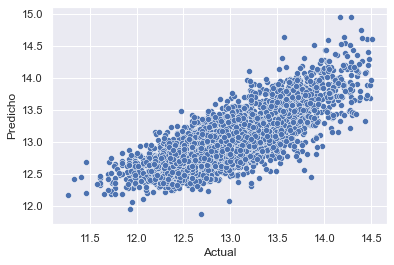

In [85]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [86]:
metricas('regresión', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,regresión,0.250954,1.938223,0.31426,0.098759,0.593835


## Regresión Lasso


Para saber más de la regresión [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

In [470]:
params = {'alpha' : [1e-15,1e-10,1e-5,1e-3,0.1, 0.3, 0.5, 0.8,1,5,10,20,30]}
lasso = Lasso()
lasso_regression = GridSearchCV(lasso, params,scoring ='neg_mean_squared_error' , cv = 5)
lasso_regression.fit(X,y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 0.3, 0.5,
                                   0.8, 1, 5, 10, 20, 30]},
             scoring='neg_mean_squared_error')

In [473]:
print(lasso_regression.best_params_)
print(lasso_regression.best_score_)

{'alpha': 1e-05}
-0.09770239130533503


In [474]:
modelo_lasso = Lasso(alpha = 1e-05).fit(X_train, y_train)
y_ajustado = modelo_lasso.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

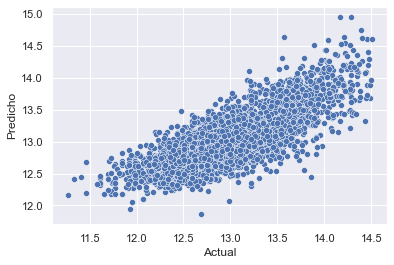

In [475]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [476]:
metricas('regresión Lasso', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,regresión Lasso,0.250952,1.938211,0.314256,0.098757,0.593846


## Regresión Elástica (Regularizada = L1 (Lasso) + L2 (Ridge)) 

Para saber más de la regresión [elástica](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) (regularizada)

In [87]:
params = {
    'alpha':[1e-15,1e-10,1e-5,1e-3,0.1, 0.3, 0.5, 0.8,1,5,10,20,30],
    'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
elastic = ElasticNet()
elastic_net = GridSearchCV(elastic, params,scoring ='neg_mean_squared_error' , cv = 5)
elastic_net.fit(X,y)

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+02, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.386e+02, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+02, tolerance: 3.730e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e+02, tolerance: 3.746e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+01, tolerance: 3.795e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+00, tolerance: 3.730e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.734e+02, tolerance: 3.746e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.954e+01, tolerance: 3.753e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.204e+01, tolerance: 3.795e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+01, tolerance: 3.730e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.014e+00, tolerance: 3.746e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.765e+01, tolerance: 3.753e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e+03, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+03, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e+03, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+03, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+03, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+03, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 0.3, 0.5,
                                   0.8, 1, 5, 10, 20, 30],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error')

In [88]:
print(elastic_net.best_params_)

{'alpha': 1e-05, 'l1_ratio': 1}


In [89]:
modelo_elastico = ElasticNet(alpha = 1e-05, l1_ratio = 1).fit(X_train,y_train)
y_ajustado = modelo_elastico.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

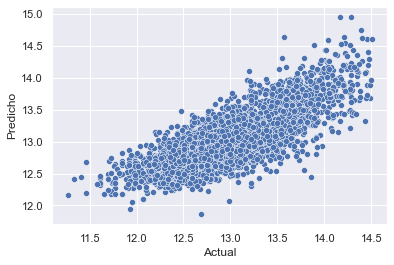

In [90]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [91]:
metricas('regresión elástica', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,regresión elástica,0.250952,1.938211,0.314256,0.098757,0.593846


## K vecinos más cercanos (Regresión)

Para saber más sobre la versión Regresión del algoritmo de los $k$ vecinos más cercanos, entre [acá](https://scikit-learn.org/stable/modules/neighbors.html#regression)

In [514]:
params ={'n_neighbors':[3,5,7,10],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
kvecinos = KNeighborsRegressor()
modelo_kvecinos = GridSearchCV(kvecinos, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_kvecinos.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [515]:
modelo_kvecinos.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}

In [517]:
modelo_vecinos = KNeighborsRegressor(algorithm= 'auto', n_neighbors= 10, weights= 'uniform').fit(X_train,y_train)
y_ajustado = modelo_vecinos.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

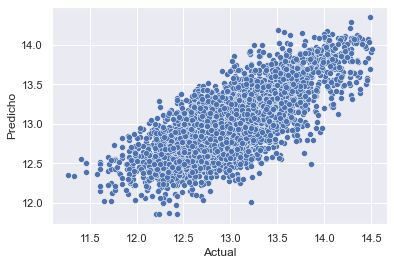

In [518]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [519]:
metricas('Vecinos más cercanos', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,Vecinos más cercanos,0.258852,1.998441,0.325569,0.105995,0.564075


## Árboles de Regresión

Para saber más sobre árboles de regresión, ingrese [acá](https://scikit-learn.org/stable/modules/tree.html)

In [535]:
params = {'max_depth':[10,12,15,18,20,30,40],
         'min_samples_leaf':[10,15,20,30,50,70,100,120]}
arbol = DecisionTreeRegressor()
modelo_arbol = GridSearchCV(arbol, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_arbol.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 12, 15, 18, 20, 30, 40],
                         'min_samples_leaf': [10, 15, 20, 30, 50, 70, 100,
                                              120]},
             scoring='neg_mean_squared_error')

In [536]:
modelo_arbol.best_params_

{'max_depth': 12, 'min_samples_leaf': 50}

In [537]:
arbol_regresion = DecisionTreeRegressor(max_depth =  12, min_samples_leaf =  50, random_state = 0).fit(X_train, y_train)
y_ajustado = arbol_regresion.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

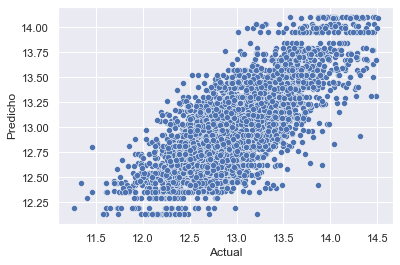

In [538]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [539]:
metricas('Árbol Regresión', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,Árbol Regresión,0.24792,1.913215,0.315127,0.099305,0.591591


## Bosque Aleatorio (Regresión)

para más información de Bosques Aleatorios, ingrese [acá](https://towardsdatascience.com/random-forest-regression-5f605132d19d) o [acá](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [ ]:
# params = { 
#     'n_estimators': [200,300,400,500],
#     'max_features': ['sqrt','log2'],
#     'max_depth' : [3,4,5,6,7],
#     'random_state' : [18]
# }
# bosque = RandomForestRegressor()
# modelo_bosque = GridSearchCV(bosque, params,scoring ='neg_mean_squared_error' , cv = 5)
# modelo_bosque.fit(X,y)

In [546]:
bosque_regresion = RandomForestRegressor().fit(X_train, y_train)
y_ajustado = bosque_regresion.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

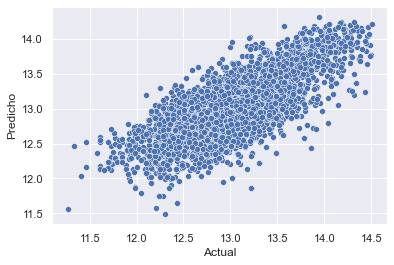

In [547]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [549]:
metricas('Bosque Regresión', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,Bosque Regresión,0.246509,1.902803,0.317035,0.100511,0.586632


## Máquina de Soporte Vectorial (Regresión)

Para saber más sobre Máquinas de Soporte Vectorial, (Support Vector Machines, SVMs) entre [acá](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/) o [acá](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [ ]:
# params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
# svm = SVR()
# modelo_svm = GridSearchCV(svm, params,scoring ='neg_mean_squared_error' , cv = 5)
# modelo_svm.fit(X,y)

In [564]:
SVM_regresion = SVR().fit(X_train, y_train)
y_ajustado = SVM_regresion.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

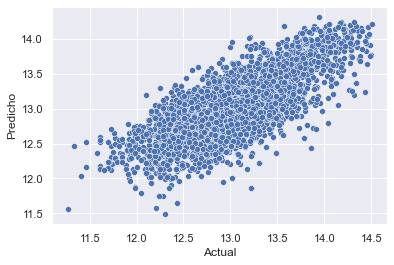

In [563]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [565]:
metricas('Máquina Soporte Vectorial', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,Máquina Soporte Vectorial,0.241555,1.867897,0.306381,0.093869,0.613947


## XGboosting (Extreme Gradient boosting)

Para consultar más información sobre XGboost, entre [acá](https://machinelearningmastery.com/xgboost-for-regression/) o [acá](https://xgboost.readthedocs.io/en/stable/python/python_intro.html).
Comparación [Bagging vs Boosting](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)

In [575]:
params ={ 
    'n_estimators': [50,70,90,100,110,120],
    'max_depth': [1,3,5,7,9,10],
    'eta': [0.3, 0.1, 0.01]}
xgboost = xgb.XGBRegressor()
modelo_xgb = GridSearchCV(xgboost, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_xgb.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [576]:
modelo_xgb.best_params_

{'eta': 0.1, 'max_depth': 5, 'n_estimators': 120}

In [577]:
xgboost_regresion = xgb.XGBRegressor(eta = 0.1, max_depth = 5, n_estimators = 120).fit(X_train, y_train)
y_ajustado = xgboost_regresion.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

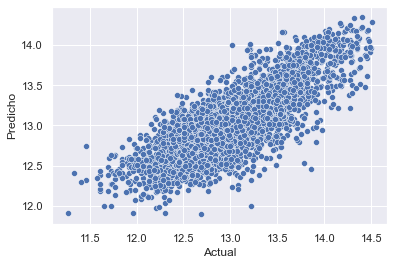

In [578]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [572]:
metricas('XGboost', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,XGboost,0.241277,1.862591,0.307515,0.094566,0.611083


In [579]:
metricas('XGboost', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,XGboost,0.237393,1.833646,0.300586,0.090352,0.628412


## Regresión Polinomial

Para consultar más sobre la regresión Polinomial, entre [acá](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386) o [acá](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)


### Tarea! 
Ajusta su modelo basedo en este [tutorial](https://data36.com/polynomial-regression-python-scikit-learn/)

In [109]:
params = {
    'degree': [2,3,4]
}
polinomio = PolynomialFeatures()
modelo_pol = GridSearchCV(polinomio, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_pol.fit(X,y)

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'PolynomialFeatures' object has no attribute '

GridSearchCV(cv=5, estimator=PolynomialFeatures(),
             param_grid={'degree': [2, 3, 4]},
             scoring='neg_mean_squared_error')

In [110]:
modelo_pol.best_params_

{'degree': 2}

In [112]:
poly = PolynomialFeatures(degree = 2).fit_transform(X_train.reshape(-1, 1))
# y_ajustado = poly.predict(X_test)

NameError: name 'x' is not defined

In [ ]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [ ]:
metricas('Polinomial', np.log1p( y_test ),y_ajustado)

## Regresión Gaussiana 

Para saber más de regresión Gaussiana, entre [acá](https://scikit-learn.org/stable/modules/gaussian_process.html) o [acá](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor). [Contenido interesante](http://gaussianprocess.org/gpml/chapters/RW.pdf)

In [115]:
params = {
    'alpha' : [1e-10,1e-5,1e-3]
}
gpr = GaussianProcessRegressor()
modelo_pol = GridSearchCV(gpr, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_pol.fit(X,y)

KeyboardInterrupt: 

In [ ]:
modelo_pol.best_params

In [134]:
modelo_gpr = GaussianProcessRegressor(random_state=0).fit(X_train, y_train)
y_ajustado = modelo_gpr.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

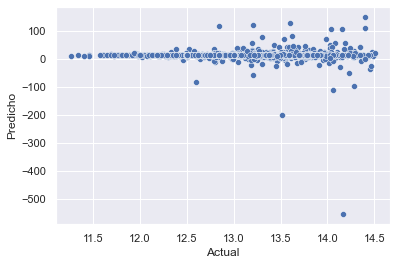

In [135]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [136]:
metricas('Gaussiana', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,Gaussiana,1.456543,10.792845,10.911006,119.050052,-488.613678


## Regresión RANSAC (Robusta)

In [126]:
params = {
    'base_estimator':[LinearRegression()], 
    'min_samples' : [2,3,4],
    'residual_threshold': [3,5,7], 
    'max_trials': [10, 30,50],
    'random_state': [0]
}
ransac = RANSACRegressor()
modelo_pol = GridSearchCV(ransac, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_pol.fit(X,y)

GridSearchCV(cv=5, estimator=RANSACRegressor(),
             param_grid={'base_estimator': [LinearRegression()],
                         'max_trials': [10, 30, 50], 'min_samples': [2, 3, 4],
                         'random_state': [0], 'residual_threshold': [3, 5, 7]},
             scoring='neg_mean_squared_error')

In [128]:
modelo_pol.best_params_

{'base_estimator': LinearRegression(),
 'max_trials': 10,
 'min_samples': 2,
 'random_state': 0,
 'residual_threshold': 3}

In [129]:
modelo_ransac = RANSACRegressor(base_estimator = LinearRegression(),
max_trials= 10,
min_samples =2,
random_state= 0,
residual_threshold=  3).fit(X_train, y_train)
y_ajustado = modelo_ransac.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

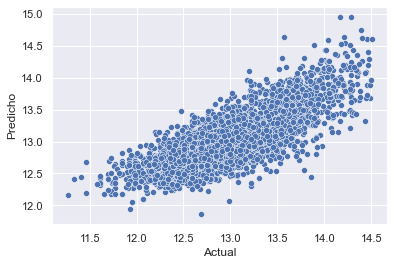

In [130]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [131]:
metricas('RANSAC', np.log1p( y_test ),y_ajustado)

,Modelo,MAE,MAPE,RMSE,MSE,R2
0,RANSAC,0.250951,1.938193,0.314264,0.098762,0.593824


# Comparación de modelos

In [92]:
mod1 = metricas_validacion_cruzada(LinearRegression(), 'Regresión Lineal', 10, X,y)

In [93]:
mod2 = metricas_validacion_cruzada(Ridge(alpha=0.3), 'Regresión Ridge (0.3)', 10, X,y)

In [94]:
mod3 = metricas_validacion_cruzada(Ridge(alpha=0.1), 'Regresión Ridge (0.1)', 10, X,y)

In [95]:
mod4 = metricas_validacion_cruzada(Lasso(alpha=0.1), 'Regresión Lasso (0.1)', 10, X,y)

In [96]:
mod5 = metricas_validacion_cruzada(Lasso(alpha=1e-05), 'Regresión Lasso (1e-05)', 10, X,y)

In [97]:
bbmod6 = metricas_validacion_cruzada(ElasticNet(alpha = 1e-05, l1_ratio = 1), 'Regresión Elástica (1e-05,1)', 10, X,y)

In [98]:
mod7 = metricas_validacion_cruzada(KNeighborsRegressor(algorithm= 'auto', n_neighbors= 10, weights= 'uniform'), 'K vecinos más cercanos (10)', 10, X,y)

In [99]:
mod8 = metricas_validacion_cruzada(DecisionTreeRegressor(max_depth =  12, min_samples_leaf =  50,random_state = 0), 'Árbol Regresión (12,50)', 10, X,y)

In [100]:
mod9 = metricas_validacion_cruzada(RandomForestRegressor(random_state = 0), 'Bosque Regresión', 10, X,y)

In [101]:
mod10 = metricas_validacion_cruzada(SVR(), 'SVM', 10, X,y)

In [102]:
mod11 = metricas_validacion_cruzada(xgb.XGBRegressor(), 'XGboost', 10, X,y)

In [103]:
mod12 = metricas_validacion_cruzada(xgb.XGBRegressor(eta = 0.1, max_depth = 5, n_estimators = 120), 'XGboost(0.1,5,120)', 10, X,y)

In [ ]:
mod13 = metricas_validacion_cruzada(, 'Polinomio(0.1,5,120)', 10, X,y)

In [132]:
mod14 =  metricas_validacion_cruzada(RANSACRegressor(base_estimator = LinearRegression(),
max_trials= 10,
min_samples =2,
random_state= 0,
residual_threshold=  3), 'RANSAC', 10, X,y)


In [133]:
pd.concat([mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9, mod11, mod12, mod14])

,Modelo,MAE,MSE,RMSE,R2
0,Regresión Lineal,0.25016+/-0.01,0.09774+/-0.01,0.31239+/-0.01,0.59502+/-0.01
0,Regresión Ridge (0.3),0.25013+/-0.01,0.09769+/-0.01,0.31231+/-0.01,0.59526+/-0.01
0,Regresión Ridge (0.1),0.25011+/-0.01,0.09769+/-0.01,0.31231+/-0.01,0.59526+/-0.01
0,Regresión Lasso (0.1),0.32488+/-0.02,0.15833+/-0.02,0.39725+/-0.02,0.34593+/-0.03
0,Regresión Lasso (1e-05),0.25012+/-0.01,0.09769+/-0.01,0.31231+/-0.01,0.59525+/-0.01
0,"Regresión Elástica (1e-05,1)",0.25012+/-0.01,0.09769+/-0.01,0.31231+/-0.01,0.59525+/-0.01
0,K vecinos más cercanos (10),0.25469+/-0.01,0.10378+/-0.01,0.32156+/-0.02,0.57125+/-0.03
0,"Árbol Regresión (12,50)",0.24418+/-0.01,0.09579+/-0.01,0.30906+/-0.02,0.60391+/-0.02
0,Bosque Regresión,0.2433+/-0.01,0.09753+/-0.01,0.31194+/-0.02,0.59635+/-0.02
0,XGboost,0.23785+/-0.01,0.09152+/-0.01,0.30231+/-0.01,0.62065+/-0.01
